In [1]:
import torch

In [2]:
import torchvision

In [3]:
from torchvision import transforms

transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./mnist', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)


Processing...
Done!


In [4]:
import matplotlib.pyplot as plt



In [5]:
import numpy as np

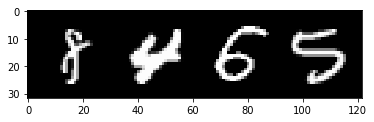

    8     4     6     5


In [6]:

# functions to show an image

classes = [i for i in range(10)]
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [7]:
images[0][0][images[0][0]>0.5]

tensor([0.9451, 0.7529, 0.7725, 0.8902, 0.8157, 0.9882, 0.5020, 0.7725, 0.5451,
        0.8196, 0.9882, 0.7725, 0.9412, 0.7725, 0.9882, 0.9804, 0.8980, 0.7843,
        0.9922, 0.6627, 0.8471, 0.9412, 0.7686, 0.9922, 0.9412, 0.9412, 0.9882,
        0.8078, 0.9922, 0.9882, 0.9882, 0.5922, 0.9451, 1.0000, 0.9922, 0.6588,
        0.6745, 0.9882, 0.9922, 0.9882, 0.6588, 0.5647, 0.9882, 0.5020, 0.9882,
        0.6588, 0.8078, 0.6941, 0.9882, 0.6588, 0.9922, 0.6588, 0.9922, 0.6588,
        0.9882, 0.6588, 0.9882, 0.6588, 0.9882, 0.6588, 0.9882, 0.6588, 0.9882,
        0.6588, 0.5529, 0.9882, 0.6588, 0.5529, 0.9922, 0.6588, 0.6510, 0.9882,
        0.6588, 0.5765, 0.9922, 0.9137, 0.9882, 0.9922])

In [98]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch
from torch.distributions import Uniform

class mlp_layer:
    def __init__(self,d_in, d_out, activation):
        """
        Activation is a function (eg. torch.nn.functional.sigmoid/relu)
        """
        print("hello ML")
        self.mu = nn.Linear(d_in, d_out)
        self.init_weights(d_in, d_out)
        self.activation = activation
    
    def __call__(self,x):
        return self.activation(self.mu(x))

    def init_weights(self, input_size, output_size, constant=1.0):
        scale = constant*np.sqrt(6.0/(input_size + output_size))
        assert(output_size > 0)
        nn.init.uniform_(self.mu.weight, -scale, scale)
        nn.init.zeros_(self.mu.bias)




        
    

In [105]:
from torch.distributions import Normal
import copy


class bayesian_mlp_layer(mlp_layer):
    def __init__(self,d_in, d_out, activation):
        """
        Activation is a function (eg. torch.nn.functional.sigmoid/relu)
        """
        super().__init__(d_in,d_out,activation)
        self.log_sigma = nn.Linear(d_in, d_out)
        self.init_log_sigma()
        
        """
        Attribute for now, but planning to do only "in-place" changes 
        """
        self.weight_sampler = Normal(self.mu.weight, \
                              torch.exp(self.log_sigma.weight))
        self.bias_sampler = Normal(self.mu.bias, \
                              torch.exp(self.log_sigma.bias))
        
        
    def __call__(self,x, sampling=True):
        print("Sampling " + str(sampling))
        if sampling:
            my_lin = nn.Linear(*self.mu.weight.shape)
            my_lin.weight = nn.Parameter(self.weight_sampler.sample())
            my_lin.bias = nn.Parameter(self.bias_sampler.sample())
            return self.activation(my_lin(x))
        else:
            return super().__call__(x)
        
        
    def init_log_sigma(self):
        nn.init.constant_(self.log_sigma.weight, -6)
        nn.init.constant_(self.log_sigma.bias, -6)


        


In [108]:
class FunctionComposition:
    def __init__(self,f_list):
        self.f_list = f_list
    
    def __call__(self, x, *optional):
        for f in self.f_list:
            x = f(x,*optional)
        return x

In [115]:
class NNFactory:
    @classmethod
    def CreateNN(cls, dims, activations):
        assert(len(dims)-1 == len(activations))
        layers = []
        for i in range(len(dims)-1):
            layers.append(bayesian_mlp_layer(dims[i],dims[i+1],activations[i]))
        return FunctionComposition(layers)

In [133]:
#a = bayesian_mlp_layer(10,5, lambda x: x)
#b = bayesian_mlp_layer(5,7, lambda x: x)
#c = FunctionComposition([a,b])

dimX=28*28
dimH=500
dimZ=50
enc_dims=[dimX, dimH, dimH, dimZ*2]
enc_activations=[F.relu,F.relu,lambda x:x]
dec_head_dims=[dimZ*2, dimH, dimH]
dec_head_activations=[F.relu,F.relu]
dec_shared_dims=[dimH, dimH, dimX]
dec_shared_activations=[F.relu,torch.sigmoid]

enc = NNFactory.CreateNN(enc_dims, enc_activations)
dec_head = NNFactory.CreateNN(dec_head_dims, dec_head_activations)
dec_shared = NNFactory.CreateNN(dec_shared_dims, dec_shared_activations)
FunctionComposition([enc,dec_head,dec_shared])(torch.ones(28*28)).shape


hello ML
hello ML
hello ML
hello ML
hello ML
hello ML
hello ML
Sampling True
Sampling True
Sampling True
Sampling True
Sampling True
Sampling True
Sampling True


torch.Size([784])

In [ ]:
def construct_optimizer(X_ph, enc, dec, ll, N_data, batch_size_ph, shared_prior_params, task, K):


In [49]:
from torch.distributions import Normal

m = Normal(torch.zeros(3,5), torch.ones(3,5))
m.sample()

tensor([[-1.0856, -0.7787, -0.0074, -0.6829, -0.3844],
        [ 0.8365,  1.4918, -0.8363, -0.7680, -0.6815],
        [ 0.6664,  0.6852, -2.3059, -0.7495,  0.5809]])

In [10]:
m.loc

tensor([0.])

In [11]:
t = torch.zeros(2)

In [12]:
t = torch.tensor([1, t.unsqueeze()])

TypeError: unsqueeze() missing 1 required positional arguments: "dim"

In [13]:
dir(t)

['__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_priority__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__idiv__',
 '__ilshift__',
 '__imul__',
 '__index__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__irshift__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__long__',
 '__lshift__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pow__',
 '__radd__',
 '__rdiv__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__rfloordiv__',
 '__rmul__',
 '__rpow__',
 '__rshift__',
 '__rsub__',
 '__rtruediv__',
 '__setattr__',
 '__setitem__',
 '__setstate_

RuntimeError: shape '[3]' is invalid for input of size 2